# 4. Reflection

In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from typing import Literal
from langgraph.types import Command
from langgraph.graph import END

In [2]:
llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [3]:
def joke(state) -> str:
    print("Node: Joke")
    response = llm.invoke(input=state["messages"])

    return {
        "messages": [response]
    }

In [4]:
def reflection(state) -> Command[Literal["joke", "__end__"]]:
    print("Node: Reflection")
    joke_message = state["messages"][-1].content
    if "cat" in joke_message.lower():
        return Command(
            goto="joke",
            update={"messages": [AIMessage(content="Joke contains the word 'cat', which is not allowed. Use different wording.")]}
        )
    else:
        return Command(
            goto=END
        )

In [5]:
from langgraph.graph import StateGraph, START
from langgraph.graph import MessagesState

builder = StateGraph(MessagesState)

builder.add_node("joke", joke)
builder.add_node("reflection", reflection)

builder.add_edge(START, "joke")
builder.add_edge("joke", "reflection")

graph = builder.compile()

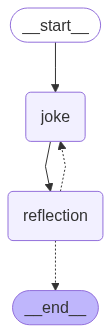

In [6]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [7]:
messages = [
    SystemMessage(
        content="You are a helpful assistant that can provide weather information for specific cities."
    ),
    HumanMessage(
        content="Tell me a joke about Cats"
    )
]

response = graph.invoke(
    input= {"messages": messages}
)

for msg in response["messages"]:
    msg.pretty_print()

Node: Joke
Node: Reflection
Node: Joke
Node: Reflection
================================ System Message ================================

You are a helpful assistant that can provide weather information for specific cities.
================================ Human Message =================================

Tell me a joke about Cats
================================== Ai Message ==================================

Sure! Here's a cat joke for you:

Why don’t cats play poker in the jungle?

Too many cheetahs!
================================== Ai Message ==================================

Joke contains the word 'cat', which is not allowed. Use different wording.
================================== Ai Message ==================================

Why did the kitty sit on the computer?

Because it wanted to keep an eye on the mouse!
